# Unzipping the Pre-processed Data

In [ ]:
# Unzip the contents of pre-processed data
# Allocate them into "/content/Kevin-MIE1517-processeddata"
# !unzip "/content/drive/MyDrive/Kevin-MIE1517-processeddata.zip" -d "/content/Kevin-MIE1517-processeddata"

In [1]:
# Import the necessary modules
# Important is torch.nn, torchvision, and DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
# Mount the device onto the GPU but if no GPU mount onto the CPU
# With GPU we have access to cuda capability, where we can parallelize the processing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define the image transformations
# Incoming images are 224x224
# Normalize them so that all data is same
image_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}


In [ ]:
# From where the pre-processed data was split into train, val, test
# Now define them into train_dataset, valid_dataset and test_dataset
# All of which are with batch size 32
data_dir = "Kevin-MIE1517-processeddata"
batch_size = 32

train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=image_transforms['train'])
valid_dataset = datasets.ImageFolder(root=f"{data_dir}/valid", transform=image_transforms['valid'])
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=image_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


# MODEL V1
(Note both Model V1 and Model V2 use frozen ResNet-152, only training on last layer classifier)

In [ ]:
# Define a class where we use frozen ResNet-152 model and just modify last layer to be
# a fully-connected layer where we have mutliclass-classification 1-196 different classes
# Note: we are only training on the classifier not on the frozen ResNet-152 prior layers
class ResNetWithClassifier(nn.Module):
    def __init__(self, num_classes=196):
        super(ResNetWithClassifier, self).__init__()
        # Load the pretrained ResNet-152 model
        self.backbone = models.resnet152(pretrained=True)
        # Freeze the ResNet backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
        # Replace the fully connected layer with a custom classifier
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()  # Remove the last fully connected layer
        self.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.backbone(x)  # Get features from ResNet
        x = self.classifier(x)  # Apply custom classifier
        return x

In [ ]:
# Instantiate the ResNet-152 model as an object and mount to GPU device
# Define the criterion as CrossEntropyLoss() as this is a multiclass-classification problem
# Set the opitmizer to be the Adam optimizer with learning rate of 0.001
resnet_model = ResNetWithClassifier(num_classes=196).to(device)  # Ensure the entire model is on the GPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.classifier.parameters(), lr=0.001)  # Train only the classifier parameters

In [ ]:
# Define the training code
# Here we are both training and validating and updating the parameters of the ResNetWithClassifier() model
# We also modified it so that afterwards the training, validation loss as well as the validation accuracy is shown
def train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs):
    train_losses = []
    valid_losses = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation loop
        model.eval()
        valid_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_valid_loss = valid_loss / len(valid_loader.dataset)
        valid_losses.append(epoch_valid_loss)

        accuracy = correct / total
        valid_accuracies.append(accuracy)

        # Print epoch results
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_valid_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Plotting after all epochs are completed
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Loss plot
    ax1.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    ax1.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
    ax1.set_title('Loss per Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Accuracy plot
    ax2.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy', color='green')
    ax2.set_title('Validation Accuracy per Epoch')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

Epoch 1/10
Training Loss: 3.0272, Validation Loss: 2.8780, Accuracy: 0.3473
Epoch 2/10
Training Loss: 1.8298, Validation Loss: 2.9627, Accuracy: 0.3418
Epoch 3/10
Training Loss: 1.5070, Validation Loss: 2.9950, Accuracy: 0.3569
Epoch 4/10
Training Loss: 1.3002, Validation Loss: 2.9345, Accuracy: 0.3734
Epoch 5/10
Training Loss: 1.1745, Validation Loss: 2.9665, Accuracy: 0.3801
Epoch 6/10
Training Loss: 1.0755, Validation Loss: 2.9640, Accuracy: 0.3826
Epoch 7/10
Training Loss: 0.9913, Validation Loss: 2.9970, Accuracy: 0.4010
Epoch 8/10
Training Loss: 0.9152, Validation Loss: 3.0035, Accuracy: 0.3978
Epoch 9/10
Training Loss: 0.8540, Validation Loss: 3.0959, Accuracy: 0.3926
Epoch 10/10
Training Loss: 0.8160, Validation Loss: 3.0866, Accuracy: 0.3988


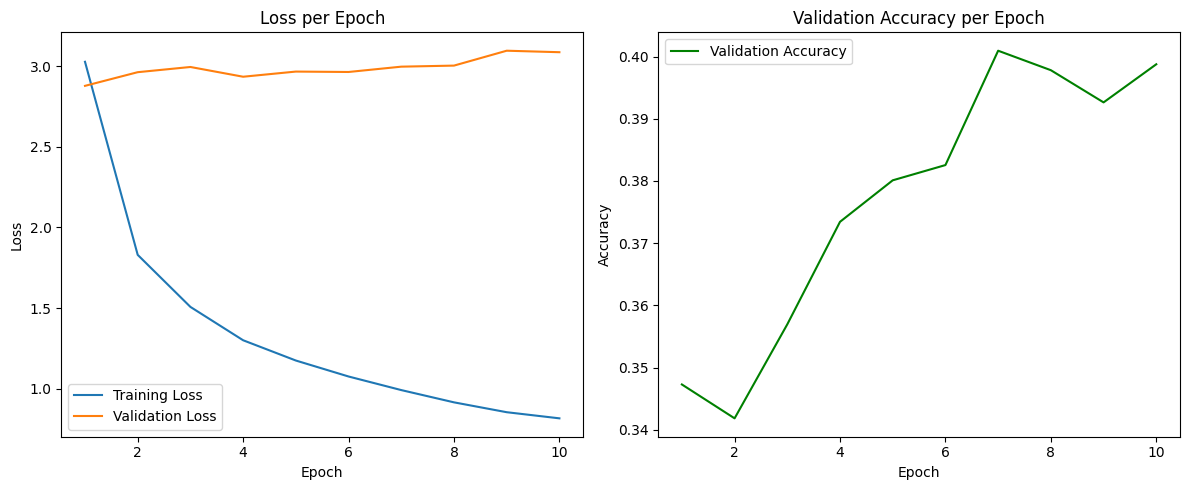

In [ ]:
# Required using Colab Pro with A100 GPU with 80 GB RAM and 40 GB VRAM
# 10 epochs trained on
# Note: model takes in ResNet-152 model, trains, validates it (notice how no test data)
num_epochs = 10
train_model(resnet_model, criterion, optimizer, train_loader, valid_loader, num_epochs)

Accuracy:

Epoch 1/10
Training Loss: 3.0272, Validation Loss: 2.8780, Accuracy: 0.3473

Epoch 2/10
Training Loss: 1.8298, Validation Loss: 2.9627, Accuracy: 0.3418

Epoch 3/10
Training Loss: 1.5070, Validation Loss: 2.9950, Accuracy: 0.3569

Epoch 4/10
Training Loss: 1.3002, Validation Loss: 2.9345, Accuracy: 0.3734

Epoch 5/10
Training Loss: 1.1745, Validation Loss: 2.9665, Accuracy: 0.3801

Epoch 6/10
Training Loss: 1.0755, Validation Loss: 2.9640, Accuracy: 0.3826

Epoch 7/10
Training Loss: 0.9913, Validation Loss: 2.9970, Accuracy: 0.4010

Epoch 8/10
Training Loss: 0.9152, Validation Loss: 3.0035, Accuracy: 0.3978

Epoch 9/10
Training Loss: 0.8540, Validation Loss: 3.0959, Accuracy: 0.3926

Epoch 10/10
Training Loss: 0.8160, Validation Loss: 3.0866, Accuracy: 0.3988

~ Roughly 40% Validation Accuracy

# MODEL V2
(Note both Model V1 and Model V2 use frozen ResNet-152, only training on last layer classifier)

In [ ]:
# Instantiate the ResNet-152 model as an object and mount to GPU device
# Using pre-trained ResNet-152 and modified it so only training output classifier
resnet_model = models.resnet152(pretrained=True) # CAN DO RES-NET50 IF TOO LARGE
for param in resnet_model.parameters():
    param.requires_grad = False

# Using pre-trained ResNet-152 and modified it so only training output classifier
# Note here we are using a fully-connected layer with outputs on probs for classes 1-196
num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_features, 196) # THIS IS ONLY 1 FC LAYER, HAVE CHOICE TO ADD MORE IF PERFORMANCE BAD

In [ ]:
# Mount the device onto the GPU but if no GPU mount onto the CPU
# With GPU we have access to cuda capability, where we can parallelize the processing
resnet_model = resnet_model.to(device)

In [ ]:
# Define the criterion as CrossEntropyLoss() as this is a multiclass-classification problem
# Set the opitmizer to be the Adam optimizer with learning rate of 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.fc.parameters(), lr=0.001)

In [ ]:
# Define the training code
# Here we are both training and validating and updating the parameters of the classifier part of the ResNet-152 model
# We also modified it so that afterwards the training, validation loss as well as the validation accuracy is shown
import matplotlib.pyplot as plt

def train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs):
    train_losses = []
    valid_losses = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation loop
        model.eval()
        valid_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_valid_loss = valid_loss / len(valid_loader.dataset)
        valid_losses.append(epoch_valid_loss)

        accuracy = correct / total
        valid_accuracies.append(accuracy)

        # Print epoch results
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_valid_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Plotting after all epochs are completed
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Loss plot
    ax1.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    ax1.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
    ax1.set_title('Loss per Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Accuracy plot
    ax2.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy', color='green')
    ax2.set_title('Validation Accuracy per Epoch')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()


Epoch 1/10
Training Loss: 1.1853, Validation Loss: 2.9489, Accuracy: 0.3711
Epoch 2/10
Training Loss: 1.0818, Validation Loss: 2.9872, Accuracy: 0.3841
Epoch 3/10
Training Loss: 1.0046, Validation Loss: 3.0175, Accuracy: 0.3876
Epoch 4/10
Training Loss: 0.9199, Validation Loss: 3.0008, Accuracy: 0.3984
Epoch 5/10
Training Loss: 0.8652, Validation Loss: 2.9860, Accuracy: 0.3952
Epoch 6/10
Training Loss: 0.8138, Validation Loss: 3.1142, Accuracy: 0.3988
Epoch 7/10
Training Loss: 0.7608, Validation Loss: 3.1108, Accuracy: 0.3981
Epoch 8/10
Training Loss: 0.7300, Validation Loss: 3.1325, Accuracy: 0.4041
Epoch 9/10
Training Loss: 0.6939, Validation Loss: 3.1521, Accuracy: 0.4000
Epoch 10/10
Training Loss: 0.6598, Validation Loss: 3.0970, Accuracy: 0.3963


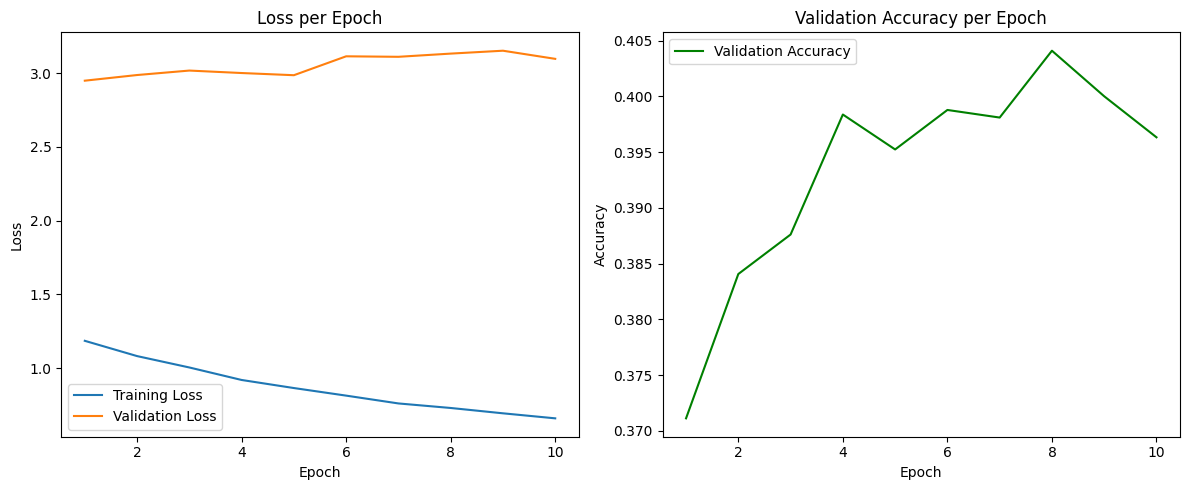

In [ ]:
# Required using Colab Pro with A100 GPU with 80 GB RAM and 40 GB VRAM
# 10 epochs trained on
# Note: model takes in ResNet-152 model, trains, validates it (notice how no test data)
num_epochs = 10
train_model(resnet_model, criterion, optimizer, train_loader, valid_loader, num_epochs)

Epoch 1/10
Training Loss: 1.1853, Validation Loss: 2.9489, Accuracy: 0.3711

Epoch 2/10
Training Loss: 1.0818, Validation Loss: 2.9872, Accuracy: 0.3841

Epoch 3/10
Training Loss: 1.0046, Validation Loss: 3.0175, Accuracy: 0.3876

Epoch 4/10
Training Loss: 0.9199, Validation Loss: 3.0008, Accuracy: 0.3984

Epoch 5/10
Training Loss: 0.8652, Validation Loss: 2.9860, Accuracy: 0.3952

Epoch 6/10
Training Loss: 0.8138, Validation Loss: 3.1142, Accuracy: 0.3988

Epoch 7/10
Training Loss: 0.7608, Validation Loss: 3.1108, Accuracy: 0.3981

Epoch 8/10
Training Loss: 0.7300, Validation Loss: 3.1325, Accuracy: 0.4041

Epoch 9/10
Training Loss: 0.6939, Validation Loss: 3.1521, Accuracy: 0.4000

Epoch 10/10
Training Loss: 0.6598, Validation Loss: 3.0970, Accuracy: 0.3963

~ Roughly 40% Validation Accuracy

Still need to be done to complete the project:

(1) Baseline Model

(2) Hyperparameter Tuning

(3) Testing on the test set

(4) Inference on Self-curated images or video frames


In [ ]:


!jupyter nbconvert --to html /content/commented_MIE1517_group3_project_model.ipynb

[NbConvertApp] Converting notebook /content/commented_MIE1517_group3_project_model.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 470965 bytes to /content/commented_MIE1517_group3_project_model.html
